<a href="https://colab.research.google.com/github/swetha9550/misinformation/blob/main/misinformation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries (run in terminal if not already installed)
# !pip install pandas scikit-learn nltk seaborn matplotlib joblib

# Import libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Download NLTK data (updated to include punkt_tab)
nltk.download('punkt_tab')  # Updated to download the correct tokenizer data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Display plots inline
%matplotlib inline

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    """Clean and preprocess text data."""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, URLs, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W|\d', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
def load_and_prepare_data(fake_path, true_path):
    """Load and combine fake and true news datasets."""
    # Load datasets
    fake_df = pd.read_csv('/content/Fake.csv')
    true_df = pd.read_csv('/content/True.csv')

    # Add labels: 1 for fake, 0 for true
    fake_df['label'] = 1
    true_df['label'] = 0

    # Combine datasets
    df = pd.concat([fake_df, true_df], ignore_index=True)

    # Use 'text' column, fill missing values
    df['text'] = df['text'].fillna('')

    # Preprocess text
    df['cleaned_text'] = df['text'].apply(preprocess_text)

    return df

# Update paths to your dataset files
fake_path = 'data/Fake.csv'
true_path = 'data/True.csv'

# Load data
print("Loading and preprocessing data...")
df = load_and_prepare_data('/content/Fake.csv', '/content/True.csv')

# Display first few rows
df[['text', 'cleaned_text', 'label']].head()

Loading and preprocessing data...


,text,cleaned_text,label
0,Donald Trump just couldn t wish all Americans ...,donald trump wish americans happy new year lea...,1
1,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...,1
2,"On Friday, it was revealed that former Milwauk...",friday revealed former milwaukee sheriff david...,1
3,"On Christmas day, Donald Trump announced that ...",christmas day donald trump announced would bac...,1
4,Pope Francis used his annual Christmas Day mes...,pope francis used annual christmas day message...,1


In [ ]:
# Split data into train+validation (90%) and holdout (10%)
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    df['cleaned_text'], df['label'], test_size=0.1, random_state=42
)

# Split train+validation into train (70%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2222, random_state=42  # 0.2222 of 90% = 20% of total
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Holdout set size: {len(X_holdout)}")

Training set size: 31429
Validation set size: 8979
Holdout set size: 4490


Training model...
Validation Accuracy: 0.9538

Classification Report:
              precision    recall  f1-score   support

        True       0.95      0.95      0.95      4327
        Fake       0.96      0.95      0.96      4652

    accuracy                           0.95      8979
   macro avg       0.95      0.95      0.95      8979
weighted avg       0.95      0.95      0.95      8979



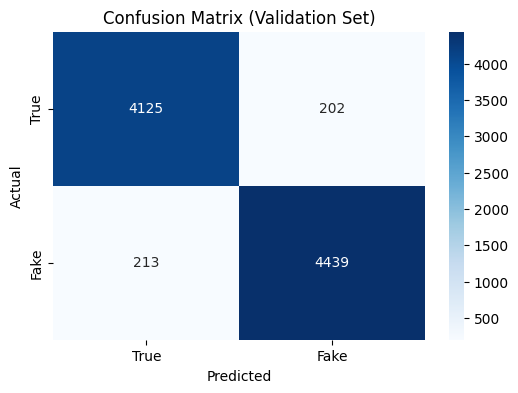

In [ ]:
from sklearn.naive_bayes import MultinomialNB  # Added import for MultinomialNB

def train_model(X_train, X_val, y_train, y_val):
    """Train and evaluate the model."""
    # Initialize TF-IDF vectorizer with updated parameters
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

    # Transform text to TF-IDF features
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)

    # Train Multinomial Naive Bayes model
    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)  # Ensure the model is fitted

    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Evaluate
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['True', 'Fake']))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
    plt.title('Confusion Matrix (Validation Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model, vectorizer

# Train and evaluate
print("Training model...")
model, vectorizer = train_model(X_train, X_val, y_train, y_val)

In [ ]:
df['label'].value_counts()

,count
label,
1,23481
0,21417


Running accuracy tests...
5-Fold Cross-Validation Scores: [0.95275215 0.94925231 0.95211581 0.95402482 0.95513126]
Mean CV Accuracy: 0.9527 (±0.0040)

Holdout Set Accuracy: 0.9503

Holdout Set Classification Report:
              precision    recall  f1-score   support

        True       0.95      0.94      0.95      2106
        Fake       0.95      0.96      0.95      2384

    accuracy                           0.95      4490
   macro avg       0.95      0.95      0.95      4490
weighted avg       0.95      0.95      0.95      4490



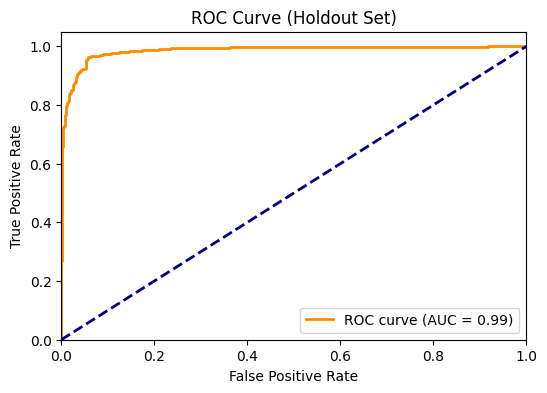

In [ ]:
def accuracy_tests(model, vectorizer, X_train, y_train, X_holdout, y_holdout):
    """Perform additional accuracy tests."""
    # Transform training and holdout data
    X_train_tfidf = vectorizer.transform(X_train)
    X_holdout_tfidf = vectorizer.transform(X_holdout)

    # 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    print("5-Fold Cross-Validation Scores:", cv_scores)
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

    # Holdout set evaluation
    y_holdout_pred = model.predict(X_holdout_tfidf)
    holdout_accuracy = accuracy_score(y_holdout, y_holdout_pred)
    print(f"\nHoldout Set Accuracy: {holdout_accuracy:.4f}")
    print("\nHoldout Set Classification Report:")
    print(classification_report(y_holdout, y_holdout_pred, target_names=['True', 'Fake']))

    # ROC Curve
    y_holdout_proba = model.predict_proba(X_holdout_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_holdout, y_holdout_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Holdout Set)')
    plt.legend(loc="lower right")
    plt.show()

    # Save ROC curve
    plt.savefig('roc_curve.png')
    plt.close()

# Run accuracy tests
print("Running accuracy tests...")
accuracy_tests(model, vectorizer, X_train, y_train, X_holdout, y_holdout)

In [ ]:
# Save model and vectorizer
joblib.dump(model, 'misinformation_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("Model and vectorizer saved.")

Model and vectorizer saved.


In [ ]:
def predict_new_text(model, vectorizer, text):
    """Predict if a new text is misinformation."""
    # Preprocess the input text
    cleaned_text = preprocess_text(text)
    # Transform to TF-IDF
    text_tfidf = vectorizer.transform([cleaned_text])
    # Predict
    prediction = model.predict(text_tfidf)[0]
    return "Misinformation (Fake)" if prediction == 1 else "Legitimate (True)"

# Test with sample posts
sample_posts = [
    "Breaking: New vaccine causes superpowers, says anonymous source!",
    "Government releases official report on climate change impacts."
]
print("\nTesting with sample posts:")
for post in sample_posts:
    result = predict_new_text(model, vectorizer, post)
    print(f"Post: {post}\nPrediction: {result}\n")


Testing with sample posts:
Post: Breaking: New vaccine causes superpowers, says anonymous source!
Prediction: Misinformation (Fake)

Post: Government releases official report on climate change impacts.
Prediction: Misinformation (Fake)



In [ ]:
new_post = "Aliens landed in New York, says unverified report!"
print(predict_new_text(model, vectorizer, new_post))

Misinformation (Fake)


In [ ]:
new_post1 = "New vaccine causes superpowers, says anonymous source!"
print(predict_new_text(model, vectorizer, new_post1))

Misinformation (Fake)


In [ ]:
new_post2 = "WHO releases 2025 global health report: Vaccination rates reach 90% in low-income countries."
print(predict_new_text(model, vectorizer,new_post2))

Legitimate (True)


In [ ]:
new_post2 = "NASA confirms successful launch of Artemis IV mission to the Moon on June 1, 2025."
print(predict_new_text(model, vectorizer,new_post2))

Legitimate (True)
